In [124]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from SimPEG.EM.Static import Utils as StaticUtils
from pymatsolver import MumpsSolver
from ipywidgets import interact, IntSlider
import timeit
import itertools
import sys
sys.path.append("../notebooks/utilcodes/")
from vizutils import viz, gettopoCC, vizEJ
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [125]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# xc = 300+5.57e5
# yc = 600+7.133e6
# zc = 425.
# mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]
sigma = mesh.readModelUBC("../notebooks/DC/VTKout_DC.dat")
airind = sigma == 1e-8

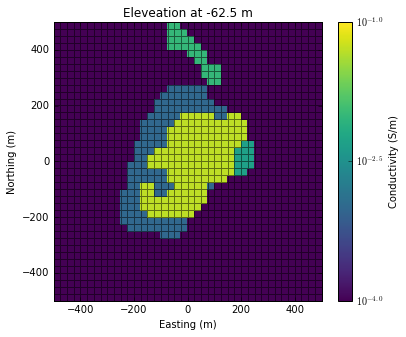

In [126]:
viz(mesh, sigma, 28, airind)

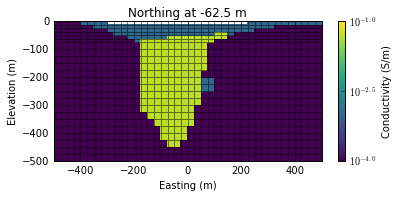

In [127]:
viz(mesh, sigma, 28, airind, normal="Y")

(<matplotlib.collections.QuadMesh at 0x161508150>,
 <matplotlib.lines.Line2D at 0x1612825d0>)

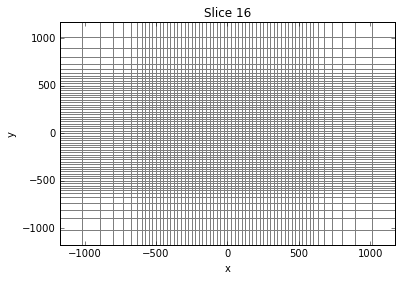

In [128]:
mesh.plotSlice(sigma*np.nan, grid=True)

In [129]:
# print mesh

In [130]:
# print  mesh.vectorCCz

In [131]:
# Identify air cells
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)

In [132]:
dx = 25.
x0_core, y0_core, z0_core = -600, -600, -500. 

In [133]:
np.arange(7)*100 + -312.5

array([-312.5, -212.5, -112.5,  -12.5,   87.5,  187.5,  287.5])

In [134]:
# mesh.vectorCCx

In [135]:
# Define electrode locations

elecSpace = 100.
coreOffset = 100 + dx/2.

# x locations
# elecX = np.linspace(x0_core + coreOffset , np.abs(x0_core) - coreOffset, num=((2*(np.abs(x0_core)-coreOffset))/elecSpace) + 1)
# nElecX = elecX.size
# y locations
# elecY = np.linspace(y0_core + coreOffset , np.abs(y0_core) - coreOffset, num=((2*(np.abs(y0_core)-coreOffset))/elecSpace) + 1)
# nElecY = elecY.size

# Insure that electrode x and y locations fall at cell centres
nskip = 4
elecX = mesh.vectorCCx[np.logical_and(mesh.vectorCCx > -300, mesh.vectorCCx < 320)][::nskip]
elecY = mesh.vectorCCy[np.logical_and(mesh.vectorCCy > -300, mesh.vectorCCy < 320)][::nskip]
nElecX = elecX.size
nElecY = elecY.size

elecX_grid,elecY_grid = np.meshgrid(elecX,elecY)

EW_Lines_Locs = []
EW_Lines_Id =[]
for ii in range(0, nElecY): 
    EW_Lines_Locs.append(np.vstack([elecX_grid[ii,:], elecY_grid[ii,:]]).T)
    EW_Lines_Id.append(np.arange(nElecX*ii,nElecX*ii + nElecX,1))
    
# Create full electrode key which maps electrode Ids and locations
elecLoc = np.vstack(EW_Lines_Locs)

# Drape to topography to get z-value
elecCC_Inds = Utils.closestPoints(mesh2D, elecLoc)
elecLoc_topo = np.c_[elecLoc[:,0], elecLoc[:,1], topoCC[elecCC_Inds]]

nElec = elecLoc_topo.shape[0]
elecId = np.arange(0,nElec,1)
elecLocKey = np.hstack([Utils.mkvc(elecId,2),elecLoc_topo])    

In [136]:
# Create dipole-dipole sequence for each EW line

# Identify Tx dipoles on each line
EW_Line_TxElecInd = []
EW_LineId = []
EW_nLines = nElecY
for nr, Line_ElecIds in enumerate(EW_Lines_Id):
    Line_nElec = Line_ElecIds.shape[0]
    for ii in Line_ElecIds[0:-1]:
        for jj in np.arange(ii+1,np.max(Line_ElecIds)+1,1):
            EW_Line_TxElecInd.append([ii , jj])
            EW_LineId.append([nr])

EW_Line_TxElecInd = np.array(EW_Line_TxElecInd)
EW_LineId = np.array(EW_LineId)
nTx = np.array(EW_Line_TxElecInd).shape[0]  
nTx_Line = nTx/EW_nLines

# print nTx
# print nTx_Line
# print EW_Line_TxElecInd[0:nTx_Line,:]
    

In [137]:
EW_LineId.shape

(147, 1)

In [138]:
dataDict = {}
# nRxList = []
# Iterate over Tx and select possible Rx for each
# nTx = 7 # just for testing
for nr, Tx in enumerate(EW_Line_TxElecInd):
    LineId = EW_LineId[nr]
    useableRxElecs = np.setdiff1d(EW_Lines_Id[LineId[0]],Tx)
    RxPairs = itertools.combinations(useableRxElecs,2) # n choose k combinations
    
    # Extract data from combinations object
    RxPairList = []
    for ii in RxPairs:
        RxPairList.append(tuple(ii))

    RxPairArray = np.array(RxPairList, dtype=int)
    nRx = RxPairArray.shape[0]
#     nRxList.append([nRx])
    
    A = Tx[0]*np.ones((nRx,1), dtype=int)
    B = Tx[1]*np.ones((nRx,1), dtype=int)
    LineIdVec = LineId*np.ones((nRx,1), dtype=int)
    dataArray = np.hstack([LineIdVec,A,B,RxPairArray])
    dataDict[nr] = dataArray

In [139]:
# plt.plot(ALoc[0], ALoc[1], 'b.')
# plt.plot(BLoc[0], BLoc[1], 'r.')
# plt.plot(MLoc[:,0], MLoc[:,1], 'ko')
# plt.plot(NLoc[:,0], NLoc[:,1], 'go')

In [140]:
srcLists = []
Tx = []
Rx = []
for itx in range (nTx):   
    ALoc = elecLocKey[:,1:][dataDict[itx][0,1],:]
    BLoc = elecLocKey[:,1:][dataDict[itx][0,2],:]
    MLoc = elecLocKey[:,1:][dataDict[itx][:,3],:]
    NLoc = elecLocKey[:,1:][dataDict[itx][:,4],:]    
    Rx.append([MLoc, NLoc])
    Tx.append([ALoc, BLoc])
    rx = DC.Rx.Dipole(MLoc, NLoc)    
    src = DC.Src.Dipole([rx], np.array(ALoc),np.array(BLoc))    
    srcLists.append(src)  
    
    

In [141]:
# Model mappings 
expmap = Maps.ExpMap(mesh)
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap

In [142]:
# reference model
m0 = np.ones_like(sigma)[~airind]*np.log(1e-4)

In [143]:
%%time
# Setup forward modelling
survey = DC.Survey(srcLists)
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigma)[~airind]
dobs = survey.dpred(mtrue)

CPU times: user 33.4 s, sys: 2.54 s, total: 35.9 s
Wall time: 13.5 s


In [144]:
# problem.Ainv.clean()

In [145]:
dcdata = Survey.Data(survey, v=dobs)

In [146]:
dobs.shape[0]/7

210

In [147]:
# dataDict

In [148]:
LineID = []
for itx in range(nTx):
    LineID.append(dataDict[itx][:,0])
LineID = np.hstack(LineID)    

In [149]:
numberlines = np.unique(LineID).shape[0]

In [150]:
srcid = np.argwhere(EW_LineId.flatten()==0)

In [151]:
# srcLists[srcid_temp for srcid_temp in srcid]

In [152]:
survey2Ds = []
for iline in range(numberlines):
    srcid = np.argwhere(EW_LineId.flatten()==iline)
    srclist2d = []
    for srcid_temp in srcid:
        srclist2d.append(srcLists[srcid_temp])        
    survey2D= DC.Survey(srclist2d)      
    problem2D = DC.Problem3D_CC(mesh)
    problem2D.pair(survey2D)
    survey2D.dobs = dobs[LineID==iline]
    survey2Ds.append(survey2D)

/Users/Mike/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [153]:
import pickle
DCsetup = {"Tx": Tx, "Rx": Rx, "sigma":sigma}
outputs = open("DCsetup_dpdp", 'wb')
pickle.dump(DCsetup, outputs)
outputs.close()

In [154]:
DCsetup = pickle.load(open("DCsetup_dpdp", 'rb'))

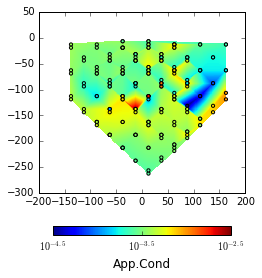

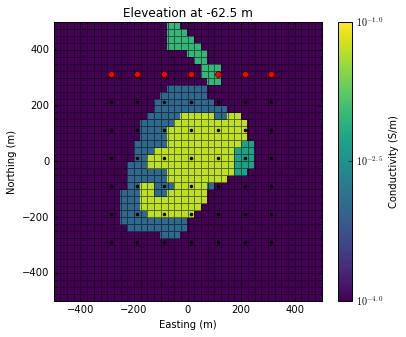

In [155]:
from SimPEG import EM
iline = 6
fig, ax = plt.subplots(1,1, figsize = (10, 4))
survey2D = survey2Ds[iline]
ph, leg = EM.Static.Utils.plot_pseudoSection(survey2D, ax, dtype='appc')
viz(mesh, sigma, 28, airind)
plt.plot(elecX_grid, elecY_grid, 'k.')
plt.plot(elecX_grid[iline,:], elecY_grid[iline,:], 'ro')


In [156]:
# from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
# regmap = Maps.IdentityMap(nP=m0.size)
# std = 0.05
# eps = 1e-3
# survey.std = std
# survey.eps = eps
# #TODO put warning when dobs is not set!
# survey.dobs = dobs
# dmisfit = DataMisfit.l2_DataMisfit(survey)
# reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
# # reg.wght = depth[~airind]
# opt = Optimization.InexactGaussNewton(maxIter = 20)
# invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# # Create an inversion object
# beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
# target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
# reg.alpha_s = 1e-4
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
# problem.counter = opt.counter = Utils.Counter()
# opt.LSshorten = 0.5
# opt.remember('xc')
# # mopt = inv.run(m0)
# # sigopt = mapping*mopt
# # np.save("sigest", sigopt)

In [157]:
sigopt = np.load("sigest.npy")
# sigopt = mapping*mopt

In [160]:
# from SimPEG import Survey
dobs = survey.dpred(sigopt)
obsdata = survey.Data(survey, v=dobs)
preddata = survey.Data(survey, v=datapred)

AssertionError: 

In [ ]:
figsize(8,3)
plt.plot(obsdata[src1, rx_y])
plt.plot(preddata[src1, rx_y], '.')

In [ ]:
# interact(lambda ind: viz(mesh, sigma, ind, airind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=28))

(-600, 600)

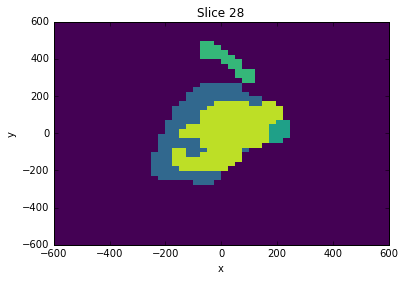

In [107]:
mesh.plotSlice(np.log10(sigma), clim=(-4, -1), pcolorOpts={'cmap':'viridis'}, normal="Z", ind=28)
xlim(-600, 600)
ylim(-600, 600)

In [100]:
# interact(lambda ind: viz(mesh, sigopt, ind, airind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=28),label='Conductivity (S/m)', scale='log', clim=(-4, -2))

(-600, 600)

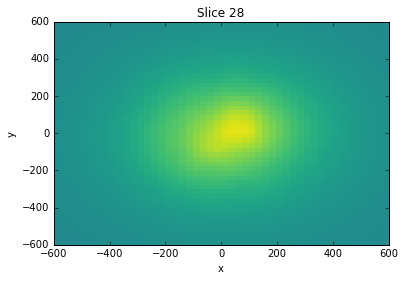

In [106]:
mesh.plotSlice(np.log10(sigopt), clim=(-4, -2.5), pcolorOpts={'cmap':'viridis'}, normal="Z", ind=28)
xlim(-600, 600)
ylim(-600, 600)

In [112]:
# interact(lambda ind: viz(mesh, sigma, ind, airind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

(-600, 0)

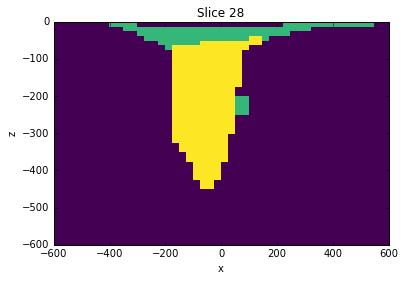

In [111]:
mesh.plotSlice(np.log10(sigma), clim=(-4, -2.5), pcolorOpts={'cmap':'viridis'}, normal="Y", ind=28)
xlim(-600, 600)
ylim(-600, 0)

In [113]:
# interact(lambda ind: viz(mesh, sigopt, ind, airind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

(-600, 0)

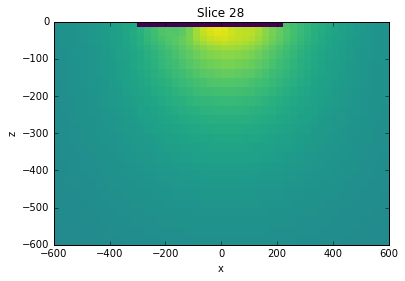

In [116]:
mesh.plotSlice(np.log10(sigopt), clim=(-4, -2.5), pcolorOpts={'cmap':'viridis'}, normal="Y", ind=28)
xlim(-600, 600)
ylim(-600, 0)

In [37]:
import pickle
Results = {"mesh":mesh, "model_true":sigma, "model_pred":sigopt, "Obs":dobs}
outputs = open("DCresults", 'wb')
pickle.dump(Results, outputs)
outputs.close()